#### Overview
- Reproducing https://medium.com/@dave.cote.msc/hybrid-multimodal-neural-network-architecture-combination-of-tabular-textual-and-image-inputs-7460a4f82a2e
- This script transfer-learn a model to classify the images to good and bad, before the next steps
- VGG16 model is used as a feature extractor and then feeding its output to a Logistic Regression model. 

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import datetime
import pickle

# keras imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Layer
from keras import backend as K

# other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import h5py
import json
import time

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

2023-07-20 06:20:47.019562: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 06:20:47.070425: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 06:20:47.072032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 06:20:50.785818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#High-level definitions
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        

In [3]:
#User Input 
config={
  "model"           : "vgg16",
  "weights"         : "imagenet",
  "include_top"     : False,

  "train_path"      : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/train/",
  "test_path"       : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/test/",
  "features_path"   : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/features.h5",
  "labels_path"     : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/labels.h5",
  "results"         : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/results.txt",
  "classifier_path" : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/classifier.pickle",
  "model_path"      : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/model",
  "label_encoder_path"      : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/label_encoder.pickle",

  "test_size"       : 0.20,
  "seed"            : 9,
  "num_classes"     : 2
}

#### Loading base VGG16 model and weights (imagenet)

In [4]:
# config variables
model_name  = config["model"]
weights     = config["weights"]
include_top = config["include_top"]
train_path  = config["train_path"]
features_path   = config["features_path"]
labels_path = config["labels_path"]
test_size   = config["test_size"]
results     = config["results"]
model_path  = config["model_path"]
label_encoder_path    = config["label_encoder_path"]


Here we are loading the base VGG16 model with weights and then excluding the top dense layer
This means that the second last fully connected (fc1) layer will be the new output layer.

In [5]:

if model_name == "vgg16":
    base_model = VGG16(weights=weights)#, include_top=True)
    model = Model(inputs = base_model.input, outputs = base_model.get_layer('fc1').output)
    image_size = (224, 224)
else:
    base_model = None

print ("Successfully loaded base model and model...")

2023-07-20 06:21:10.827453: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-07-20 06:21:11.123575: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-07-20 06:21:11.229187: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


Successfully loaded base model and model...


2023-07-20 06:21:15.174091: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


#### Using VGG16 to extract features for each label (good, bad)

Images can be prepared for a given model using the preprocess_input() function; e.g., pixel scaling is performed in a way that was performed to images in the training dataset when the model was developed. For example:
```
from keras.applications.vgg16 import preprocess_input
images = ...
prepared_images = preprocess_input(images)
```
Ref
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

In [6]:
# Encode the labels
train_labels = os.listdir(train_path)
le = LabelEncoder()
le.fit([tl for tl in train_labels])

# variables to hold features and labels
features = []
labels   = []

# loop over all the labels in the folder
count = 1
for i, label in enumerate(train_labels):
    cur_path = train_path  + label +  '/'
    relevant_path = cur_path
    included_extensions = ['jpg']
    file_names = [fn for fn in os.listdir(relevant_path)
                  if any(fn.endswith(ext) for ext in included_extensions)]
    #print(cur_path)
    #print(cur_path)
    #print(len(labels))
    count = 1
    for image_path in file_names:
        img = image.load_img(train_path  + label +  '/' + image_path, target_size=image_size)
        x = image.img_to_array(img)
        #print(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x) #Get extracted feature
        flat = feature.flatten()
        features.append(flat)
        labels.append(label)
        print ("Processed - " + str(count))
        count += 1
    print ("Completed label - " + label)

1/1 [==============================] - 2s 2s/step
Processed - 1
1/1 [==============================] - 0s 167ms/step
Processed - 2
1/1 [==============================] - 0s 167ms/step
Processed - 3
1/1 [==============================] - 0s 164ms/step
Processed - 4
1/1 [==============================] - 0s 172ms/step
Processed - 5
1/1 [==============================] - 0s 168ms/step
Processed - 6
1/1 [==============================] - 0s 181ms/step
Processed - 7
1/1 [==============================] - 0s 160ms/step
Processed - 8
1/1 [==============================] - 0s 159ms/step
Processed - 9
1/1 [==============================] - 0s 163ms/step
Processed - 10
1/1 [==============================] - 0s 161ms/step
Processed - 11
1/1 [==============================] - 0s 164ms/step
Processed - 12
1/1 [==============================] - 0s 164ms/step
Processed - 13
1/1 [==============================] - 0s 161ms/step
Processed - 14
1/1 [==============================] - 0s 177ms/step
Process

In [7]:
print(len(labels))
print(len(features))
print(len(features[1]))
print(features[20].shape)

800
800
4096
(4096,)


Encode labels (good, bad)

In [8]:
# encode the labels using LabelEncoder
le = LabelEncoder()
le_labels = le.fit_transform(labels)

# get the shape of training labels
print ("Training labels: {}".format(le_labels))
print ("Training labels shape: {}".format(le_labels.shape))

Training labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

#### Generate model summary

In [9]:
#Generate model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Save features and labels (*.h5)
Also save model (*.json) and weights ( *.h5 ), separately
Also save model and weights together (*.pkl)

In [10]:
# save features and labels
h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(features))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(le_labels))

h5f_data.close()
h5f_label.close()

# save model and weights
model_json = model.to_json()
with open(model_path + str(test_size) + ".json", "w") as json_file:
    json_file.write(model_json)

pickle.dump(le, open(label_encoder_path, 'wb'))

# save weights
model.save_weights(model_path + str(test_size) + ".h5")
print("Saved model and weights to disk..")

print ("Features and labels saved..")

# end time | Not needed but it's kinda cool - CC
end = time.time()
print ("End time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))

Saved model and weights to disk..
Features and labels saved..
End time - 2023-07-20 06:30


#### Transfer-learn model and test it

In [11]:

config={
  "model"           : "vgg16",
  "weights"         : "imagenet",
  "features_path"   : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/features.h5",
  "labels_path"     : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/labels.h5",
  "classifier_path" : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/classifier.pickle",
  "model_path"      : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/model",
  "label_encoder_path"      : "/workspaces/deeplearning-multimodal-neural-network/data/images_classifier_cleaner/label_encoder.pickle",
  "test_size"       : 0.20,
  "seed"            : 9,
}

# config variables
test_size  = config["test_size"]
seed = config["seed"]
features_path = config["features_path"]
labels_path = config["labels_path"]
classifier_path = config["classifier_path"]

# import features and labels
h5f_data  = h5py.File(features_path, 'r')
h5f_label = h5py.File(labels_path, 'r')

features_string = h5f_data['dataset_1']
labels_string   = h5f_label['dataset_1']

features = np.array(features_string)
labels   = np.array(labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of features and labels
print ("[INFO] features shape: {}".format(features.shape))
print ("[INFO] labels shape: {}".format(labels.shape))

print ("[INFO] training started...")


[INFO] features shape: (800, 4096)
[INFO] labels shape: (800,)
[INFO] training started...


#### Split the training and testing data. trainData and trainLabels contain the extracted features and their corresponding labels.

In [12]:
# split the training and testing data. trainData and trainLabels contain the extracted features and their corresponding labels.
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                  np.array(labels),
                                                                  test_size=test_size,
                                                                  random_state=seed)

print ("[INFO] splitted train and test data...")
print ("[INFO] train data  : {}".format(trainData.shape))
print ("[INFO] test data   : {}".format(testData.shape))
print ("[INFO] train labels: {}".format(trainLabels.shape))
print ("[INFO] test labels : {}".format(testLabels.shape))

[INFO] splitted train and test data...
[INFO] train data  : (640, 4096)
[INFO] test data   : (160, 4096)
[INFO] train labels: (640,)
[INFO] test labels : (160,)


#### Transfer-learning
```
model.fit(trainData, trainLabels)
```


In [14]:
# Use logistic regression as the model
print ("[INFO] creating model...")
model = LogisticRegression(max_iter=5500)

# Fit (train) the logistic regression model with the training data and labels
model.fit(trainData, trainLabels)

# evaluate the model of test data
preds = model.predict(testData)

# dump classifier to file
print ("[INFO] saving model...")
pickle.dump(model, open(classifier_path, 'wb'))

[INFO] creating model...
[INFO] saving model...


#### Final confusion matrix from the test data sample

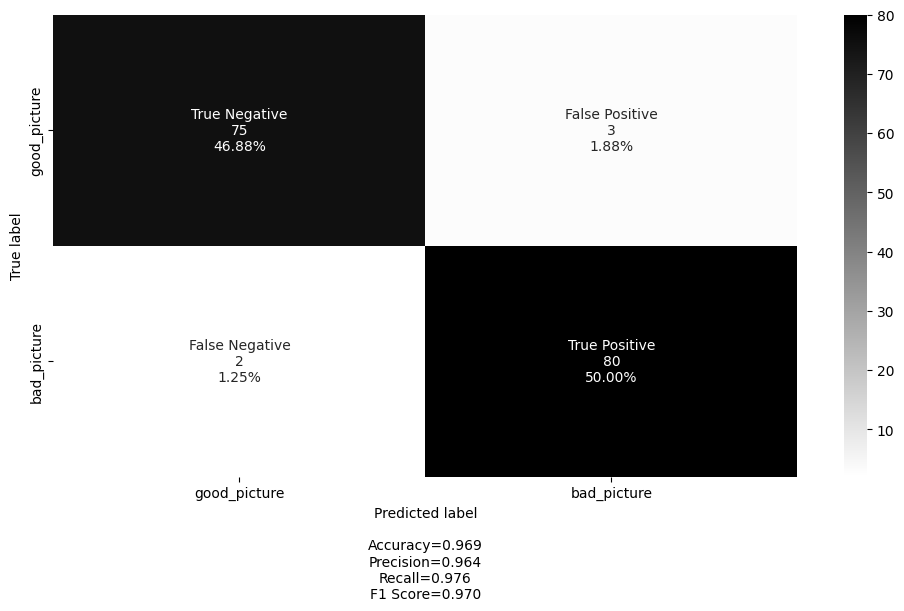

In [15]:
# plot the confusion matrix
cm = confusion_matrix(testLabels, preds)

categories = ['good_picture', 'bad_picture']
labels = ['True Negative','False Positive','False Negative','True Positive']
make_confusion_matrix(cm, figsize=(12,6), 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')